In [ ]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

from google.colab import drive

import warnings

warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Mounted at /content/drive


#1. Wave file loading and Spectrogram(Color map) visualizing

librosa 통해서 전체 data를 floating type으로 loading 한 후 sr=None으로 원래 sampling rate 유지

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/dataset/Speech Recognition/'

train_audio_path = data_path+'train/train/audio/'

filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(train_audio_path+filename,sr=None)

In [ ]:
print(sample_rate,samples,len(samples))

16000 [ 0.00042725 -0.00021362 -0.00042725 ...  0.00057983  0.00061035
  0.00082397] 16000


Calculate spectogram in logarithmic.

In [ ]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False,)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

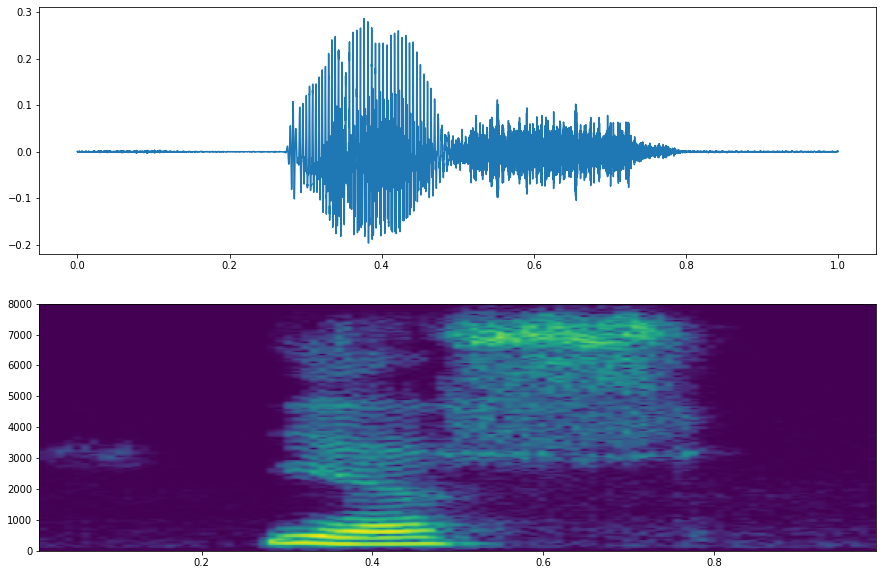

In [ ]:
freqs, times, spectrogram = log_specgram(samples,sample_rate)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(np.linspace(0,sample_rate/len(samples),sample_rate), samples)

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(spectrogram.T,aspect='auto',origin='lower',extent=[times.min(),times.max(),freqs.min(),freqs.max()])

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

MFCC(Mel-Frequency Cepstral Coeff) (kind of A-weighting)

1. 오디오 신호를 sampling rate 단위로 나눠서 푸리에 transform 적용
2. power spectrogram에 Mel scale filter를 사용해서 차원수를 줄인다.
3. Cepstral 분석을 통해 MFCC 구한다.

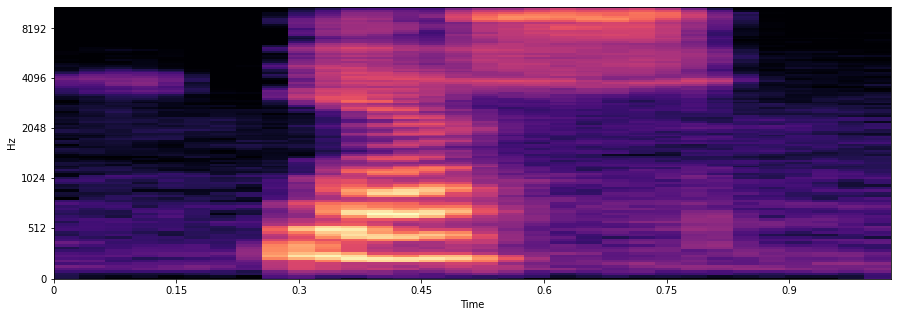

In [ ]:
S = librosa.feature.melspectrogram(samples,sr=sample_rate,n_mels=128)

log_S = librosa.power_to_db(S,ref=np.max)

plt.figure(figsize=(15,5))
librosa.display.specshow(log_S,sr=sample_rate,x_axis='time',y_axis='mel')

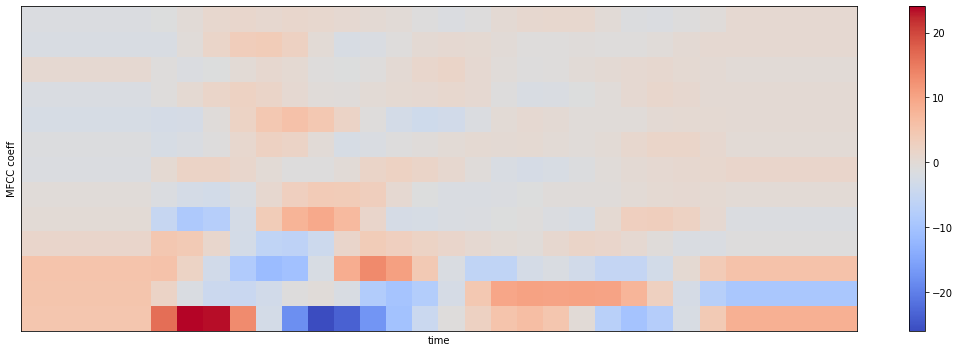

In [ ]:
mfcc = librosa.feature.mfcc(S = log_S,n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc,order=2)

plt.figure(figsize=(15,5))
librosa.display.specshow(delta2_mfcc)
plt.xlabel('time')
plt.ylabel('MFCC coeff')
plt.colorbar()
plt.tight_layout()

In [ ]:
ipd.Audio(samples, rate = sample_rate)

In [ ]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut,rate=sample_rate)

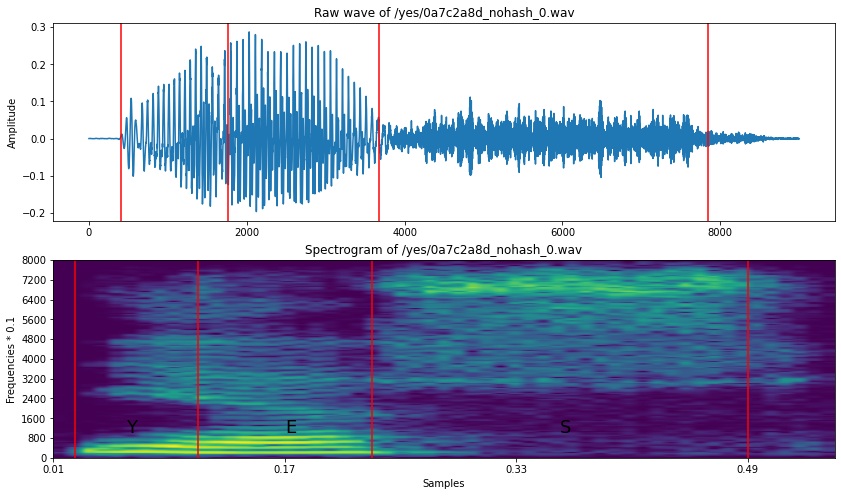

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

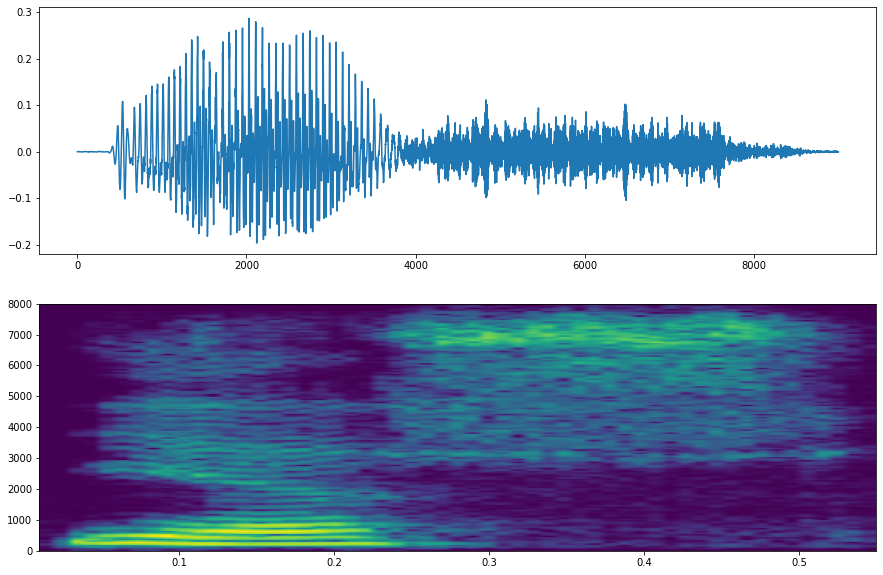

In [ ]:
freqs,times,spectrogram_cut = log_specgram(samples_cut,sample_rate)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram_cut.T,aspect='auto',origin='lower',extent=[times.min(),times.max(),freqs.min(),freqs.max()])

Resampling (Frequency range cut)

- 음성 데이터에서 필요한 부분에 관한 주파수를 제외하고 나머지 부분은 잘라주는 역할

In [ ]:
def custom_fft(y,fs):
    T = 1.0/fs #periods
    N = y.shape[0] #sample blocks
    yf = fft(y) #fft of y
    xf = np.linspace(0,1/(2*T),N//2) #length of frequency domain
    vals = 2/N*np.abs(yf[0:N//2]) #each values
    return xf,vals

In [ ]:
new_sample_rate = 8000

resampled = signal.resample(samples,int(new_sample_rate/sample_rate * samples.shape[0]))

In [ ]:
ipd.Audio(samples, rate = sample_rate)

In [ ]:
ipd.Audio(resampled,rate = new_sample_rate)

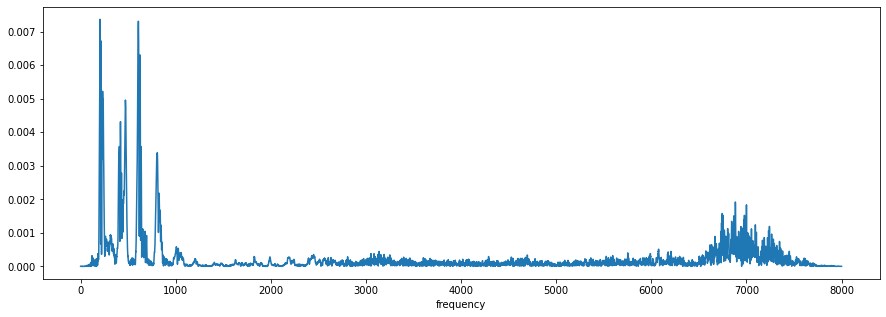

In [ ]:
xf, vals  = custom_fft(samples, sample_rate)
plt.figure(figsize=(15,5))
plt.plot(xf,vals)
plt.xlabel('frequency')
plt.show()

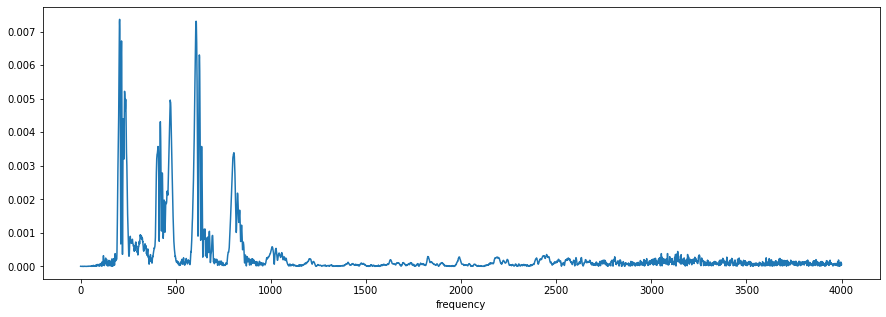

In [ ]:
new_xf, new_vals  = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(15,5))
plt.plot(new_xf,new_vals)
plt.xlabel('frequency')
plt.show()

2. DATASET INVESTIGATION

In [ ]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(train_audio_path+f)]
dirs.sort()
print('Number of labels :',len(dirs))

Number of labels : 31


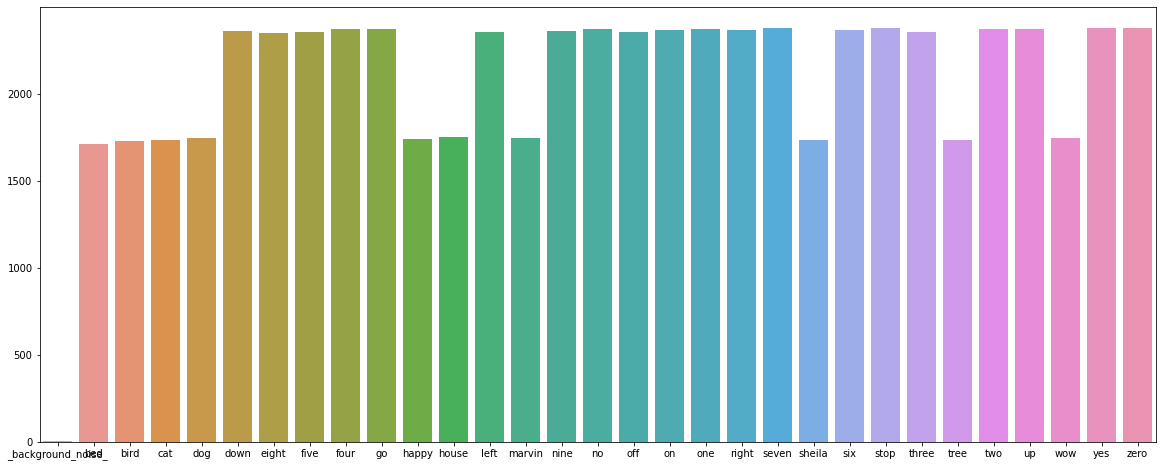

In [ ]:
number_of_recordings = []
for directory in dirs:
    waves = [f for f in os.listdir(train_audio_path+directory) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

plt.figure(figsize=(20,8))
sns.barplot(x=dirs,y=number_of_recordings)

Mean spectrogram and FFT

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


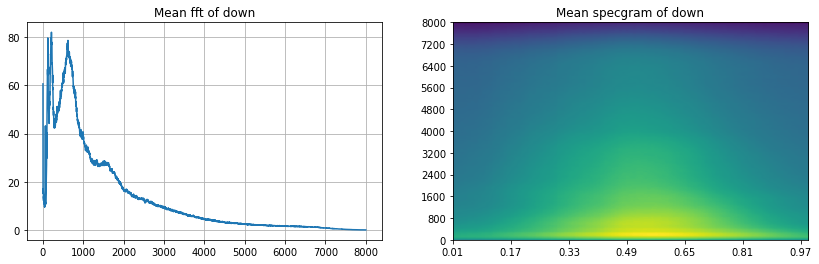

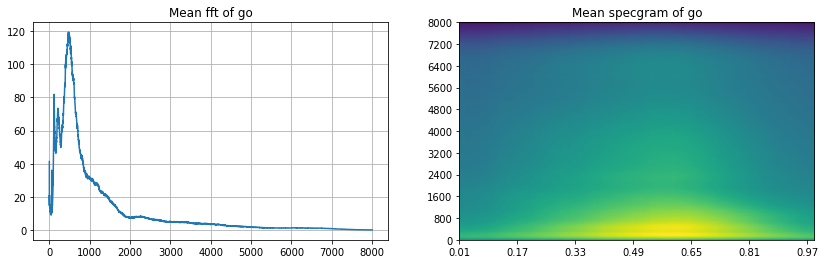

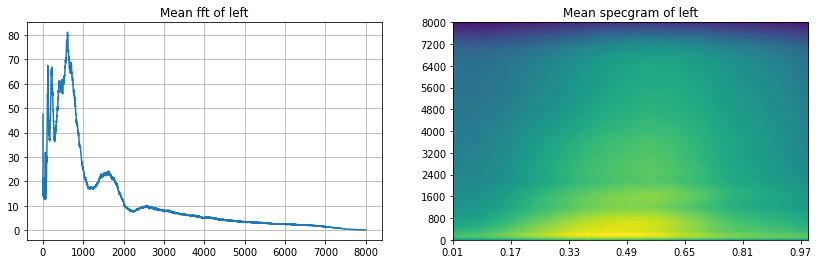

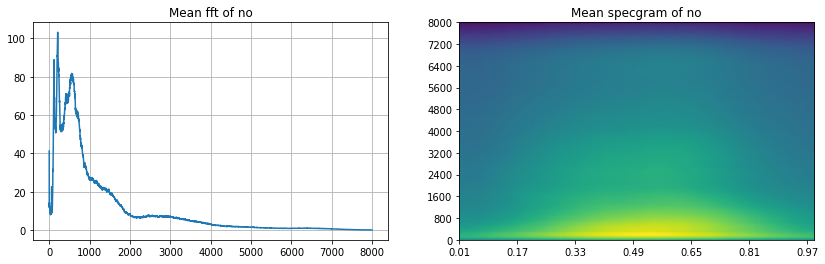

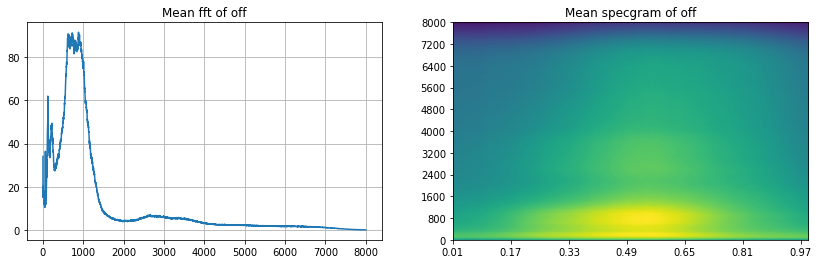

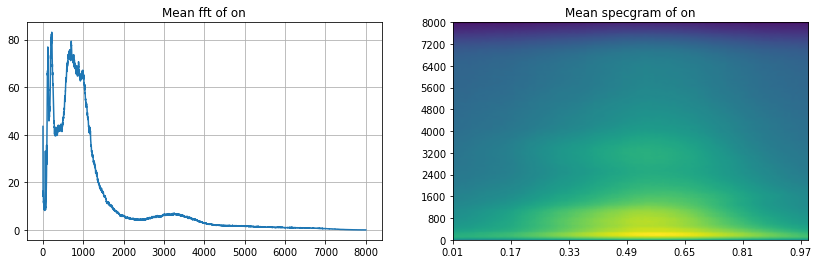

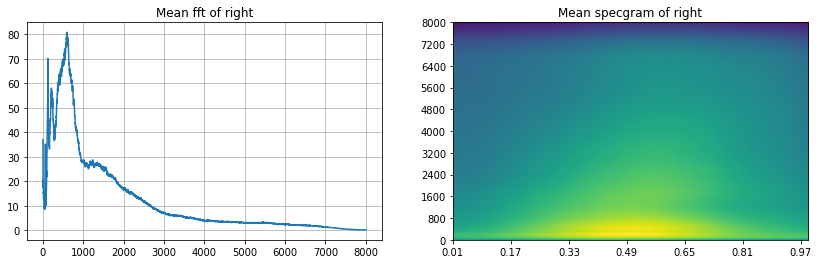

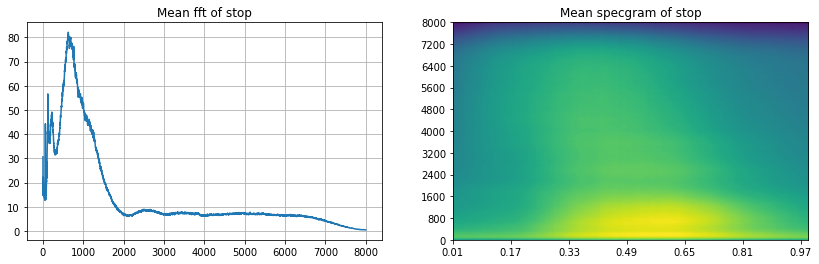

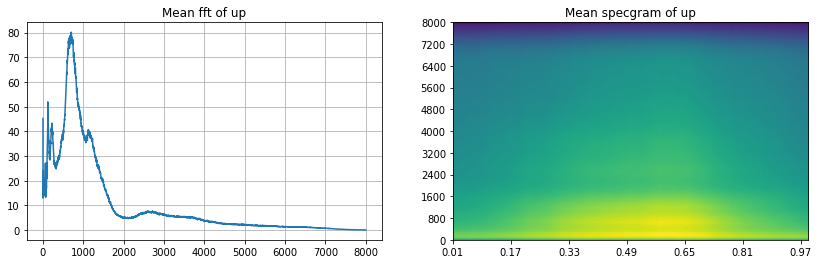

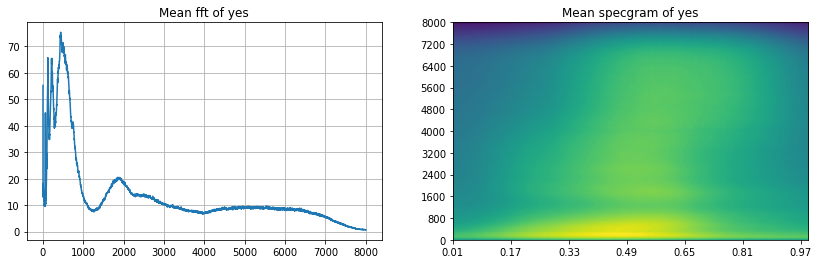

In [ ]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

In [ ]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right','on','off','stop','go']
dirs = [d for d in dirs if d in target_list]

print(dirs)

for directory in dirs:
    all_vals = []
    all_specs = []

    waves = [f for f in os.listdir(train_audio_path+directory) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + directory + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf,vals = custom_fft(samples,16000)
        all_vals.append(vals)
        freqs, times, spec = log_specgram(samples,16000)
        all_specs.append(spec)

    plt.figure(figsize=(14,4))
    plt.subplots(121)
    plt.title('Mean fft of '+directory)
    plt.plot(np.mean(np.array(all_vals),axis=0))

    plt.subplots(122)
    plt.title('Mean spectrogram of '+directory)
    plt.imshow(np.mean(np.array(all_specs),axis=0).T,aspect='auto',origin='lower',extent=[times.min(),times.max(),freqs.min(),freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()